# Leave One Out Training

## Imports

In [3]:
# Import libraries
from fastai.vision.all import *
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os
import random

## Entrenamiento LOO + logeado/guardado de modelos

In [ ]:
bocados = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(
        train_name="train",
        valid_name="validation"
    ),
    get_y=parent_label,
    item_tfms=Resize(256, ResizeMethod.Squish),
    batch_tfms=aug_transforms(
        mult=1,
        do_flip=True,
        flip_vert=False,
        p_lighting=0,
        p_affine=0.75,
        max_zoom=1.05,
        max_rotate=20
    )
)

In [4]:
loo_datasets_dir = "./loo_datasets"
save_loo_models_dir = "./loo_models"
os.makedirs(save_loo_models_dir, exist_ok=True)
datasets_names = [dataset_name for dataset_name in os.listdir(loo_datasets_dir) if os.path.isdir(os.path.join(loo_datasets_dir, dataset_name))]

In [ ]:
for dataset_name in datasets_names:
    print(f"### {dataset_name} Training ###")
    dataset_dir = os.path.join(loo_datasets_dir, dataset_name)
    dls = bocados.dataloaders(Path(dataset_dir))
    model_save_dir = os.path.join(save_loo_models_dir, dataset_name)
    os.makedirs(model_save_dir, exist_ok=True)
    print(model_save_dir)
    learn = vision_learner(dls, resnet18, metrics=error_rate, path=model_save_dir)
    learn.add_cbs([
        CSVLogger(
            fname="epochs_log.csv",
            append=False
        ),
        SaveModelCallback(every_epoch=True),
        SaveModelCallback(
            monitor="error_rate",
            fname="min_error_checkpoint"
        ),
        SaveModelCallback(
            monitor="valid_loss",
            fname="min_val_loss_checkpoint"
        ),
        SaveModelCallback(
            at_end=True,
            fname="final_checkpoint"
        )
    ])
    learn.fine_tune(50)

## Revisamos resultados épocas utilizando los csvs

02.1V0_out


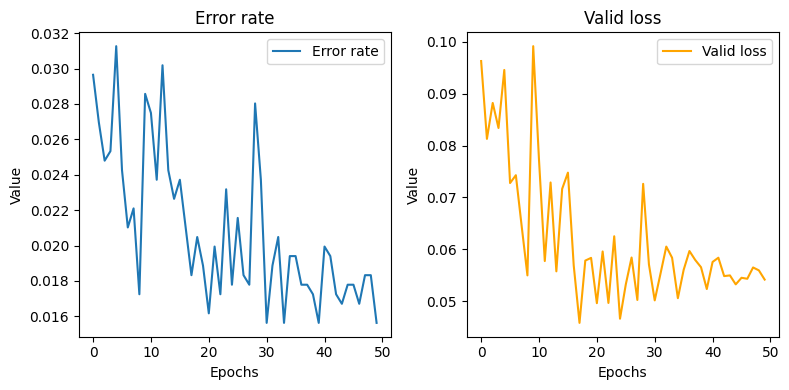

03V0_out


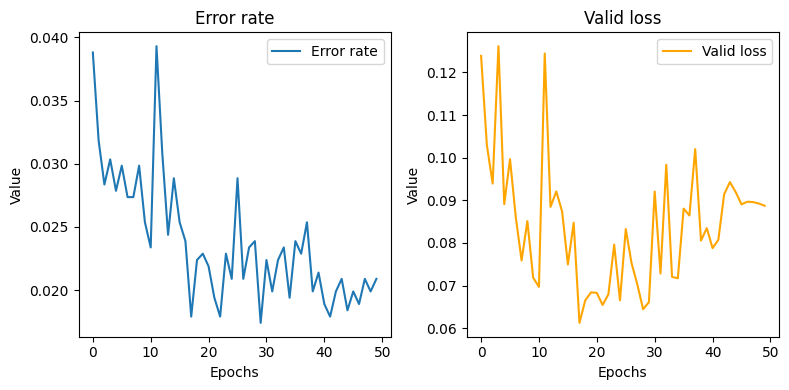

11V0_out


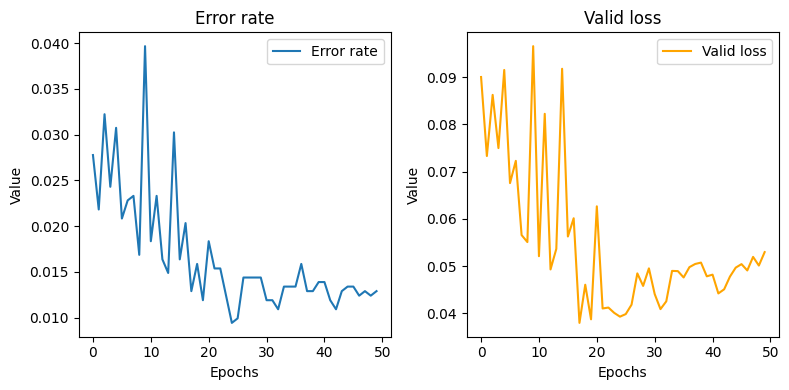

23V1_out


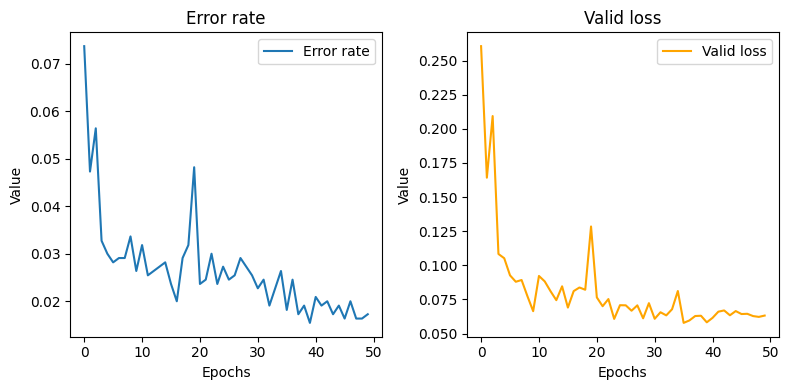

7V0_out


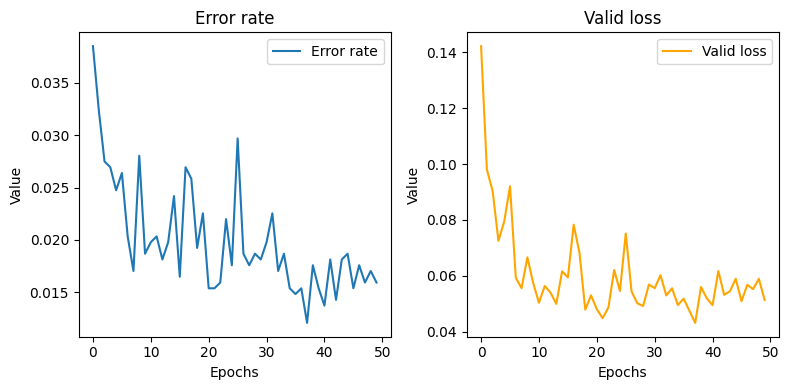

([0.015633421018719673,
  0.017412934452295303,
  0.009419930167496204,
  0.015468607656657696,
  0.012094557285308838],
 [30, 29, 24, 39, 37])

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

min_errors = []
min_err_idxs = []
for dataset_name in datasets_names:
    with open_file(os.path.join(save_loo_models_dir, dataset_name, "epochs_log.csv")) as file:
        lines = file.readlines()
        lines.pop(0)
        error_rate = []
        valid_loss = []
        for line in lines:
            values = line.split(",")
            error_rate.append(float(values[3]))
            valid_loss.append(float(values[2]))

        min_errors.append(min(error_rate))
        min_err_idxs.append(np.argmin(error_rate))

        print(dataset_name)

        # Create axes for 2 plots
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Plot list1 on the first subplot
        axes[0].plot(range(len(error_rate)), error_rate, label='Error rate')
        axes[0].set_title('Error rate')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Value')
        axes[0].legend()
        
        # Plot list2 on the second subplot
        axes[1].plot(range(len(valid_loss)), valid_loss, label='Valid loss', color='orange')
        axes[1].set_title('Valid loss')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Value')
        axes[1].legend()
        
        # Adjust layout
        plt.tight_layout()
        
        # Show the plots
        plt.show()


min_errors, min_err_idxs